In [7]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [46]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [47]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_05/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.13839% 	9.09118% 	0.04888		0.04716		0.0		1.0	
(1024,256) 	95.4% 		0.47362% 	6.44528% 	0.82382		0.80488		0.0		0.96573	
(1024,1024) 	3.04% 		1.9141% 	2.39912% 	0.02452		0.00411		0.0		0.74356	


In [48]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(99200, 1.0) 1.00000 1.00000 0.00000 	(209717, 0.8569848342924622) 0.84980 0.85698 0.00718 	(5293, 0.9823321554770318) 0.29806 0.98233 0.68427 	
(30861, 1.0) 1.00000 1.00000 0.00000 	(187403, 0.8082255990285311) 0.82183 0.80823 0.01360 	(586879, 0.9493521790341579) 0.04743 0.94935 0.90192 	
(9101, 1.0) 0.99521 1.00000 0.00479 	(183628, 0.8634086972953426) 0.80409 0.86341 0.05932 	(146491, 0.3085983510011779) 0.13357 0.30860 0.17503 	
(1927, 1.0) 0.32576 1.00000 0.67424 	(50332, 0.8519743330122854) 0.84849 0.85197 0.00348 	(140880, 1.0) 0.04306 1.00000 0.95694 	
(2053, 1.0) 0.86471 1.00000 0.13529 	(30202, 0.7892230306589061) 0.84886 0.78922 0.05964 	(237579, 0.9811542991755006) 0.29530 0.98115 0.68585 	
(42117, 1.0) 0.99998 1.00000 0.00002 	(234124, 0.8739351063513874) 0.86533 0.87394 0.00861 	(342504, 0.9340400471142521) 0.08798

(902, 1.0) 0.49055 1.00000 0.50945 	(163237, 0.8524725527771212) 0.86499 0.85247 0.01252 	(235665, 0.877502944640754) 0.11336 0.87750 0.76414 	
(55454, 1.0) 0.99994 1.00000 0.00006 	(181033, 0.8875244772735039) 0.81786 0.88752 0.06967 	(126997, 0.9116607773851589) 0.31056 0.91166 0.60110 	
(44416, 1.0) 1.00000 1.00000 0.00000 	(177928, 0.896750800039262) 0.85102 0.89675 0.04573 	(1046956, 0.9988221436984688) 0.06368 0.99882 0.93514 	
(15485, 1.0) 1.00000 1.00000 0.00000 	(33026, 0.7557993609994612) 0.80343 0.75580 0.04763 	(391227, 0.833922261484099) 0.07272 0.83392 0.76120 	
(31873, 1.0) 0.99963 1.00000 0.00037 	(141243, 0.838849874973808) 0.87581 0.83885 0.03696 	(321689, 0.16843345111896357) 0.12061 0.16843 0.04782 	
(14853, 1.0) 0.99985 1.00000 0.00015 	(166126, 0.8582062440861082) 0.84230 0.85821 0.01591 	(68758, 0.9163722025912839) 0.20398 0.91637 0.71239 	
(1053, 1.0) 0.23872 1.00000 0.76128 	(38317, 0.9089717354703442) 0.86301 0.90897 0.04596 	(5702, 0.9210836277974088) 0.04845

(6661, 1.0) 1.00000 1.00000 0.00000 	(163350, 0.8924322131732203) 0.84627 0.89243 0.04617 	(169563, 0.05653710247349822) 0.00499 0.05654 0.05155 	
(130048, 1.0) 1.00000 1.00000 0.00000 	(61892, 0.8928107242950365) 0.86038 0.89281 0.03243 	(60471, 0.9587750294464076) 0.23032 0.95878 0.72846 	
(17979, 1.0) 0.99863 1.00000 0.00137 	(125283, 0.8459302749748787) 0.84209 0.84593 0.00384 	(161864, 0.036513545347467674) 0.13132 0.03651 0.09481 	
(82179, 1.0) 1.00000 1.00000 0.00000 	(116151, 0.8642226076000623) 0.85163 0.86422 0.01259 	(362636, 0.9328621908127209) 0.10088 0.93286 0.83198 	
(53003, 1.0) 1.00000 1.00000 0.00000 	(90475, 0.9034183394347179) 0.86894 0.90342 0.03447 	(344147, 0.9269729093050648) 0.04580 0.92697 0.88117 	
(6426, 1.0) 0.99998 1.00000 0.00002 	(152337, 0.8421854008294313) 0.80976 0.84219 0.03242 	(709416, 0.7326266195524147) 0.01024 0.73263 0.72239 	
(12827, 1.0) 1.00000 1.00000 0.00000 	(27886, 0.7764456044543009) 0.83121 0.77645 0.05476 	(71721, 0.9363957597173145) 

(125697, 1.0) 1.00000 1.00000 0.00000 	(52560, 0.8729033723639321) 0.83451 0.87290 0.03840 	(403740, 0.9281507656065962) 0.06071 0.92815 0.86744 	
(14339, 1.0) 1.00000 1.00000 0.00000 	(106558, 0.8443292096306229) 0.85748 0.84433 0.01315 	(399827, 0.9163722025912839) 0.04888 0.91637 0.86749 	
(69138, 1.0) 0.99985 1.00000 0.00015 	(82580, 0.9009203398981984) 0.86634 0.90092 0.03458 	(754192, 0.9340400471142521) 0.01448 0.93404 0.91956 	
(11264, 1.0) 1.00000 1.00000 0.00000 	(125549, 0.8663760355434802) 0.86071 0.86638 0.00566 	(255332, 0.9693757361601885) 0.16883 0.96938 0.80055 	
(45580, 1.0) 0.99922 1.00000 0.00078 	(134780, 0.8161589379514356) 0.85959 0.81616 0.04343 	(468694, 0.8833922261484101) 0.01170 0.88339 0.87169 	
(57856, 1.0) 0.99998 1.00000 0.00002 	(134099, 0.9106777578451702) 0.88264 0.91068 0.02803 	(47253, 0.9893992932862191) 0.23032 0.98940 0.75908 	
(76062, 1.0) 1.00000 1.00000 0.00000 	(32529, 0.8435232689661196) 0.76440 0.84352 0.07913 	(28989, 0.9234393404004712) 0

(78208, 1.0) 1.00000 1.00000 0.00000 	(161410, 0.8882499141027351) 0.86533 0.88825 0.02292 	(624223, 0.8786808009422851) 0.48425 0.87868 0.39443 	
(120577, 1.0) 1.00000 1.00000 0.00000 	(227235, 0.8657741323531254) 0.86533 0.86577 0.00045 	(269374, 0.9022379269729094) 0.11455 0.90224 0.78768 	
(52093, 1.0) 1.00000 1.00000 0.00000 	(148840, 0.9449130299870506) 0.91529 0.94491 0.02962 	(53901, 0.790341578327444) 0.03807 0.79034 0.75228 	
(2435, 1.0) 0.99913 1.00000 0.00087 	(246011, 0.8737738788272338) 0.85498 0.87377 0.01880 	(249897, 0.11778563015312142) 0.15398 0.11779 0.03620 	
(108160, 1.0) 1.00000 1.00000 0.00000 	(165190, 0.9127046118726017) 0.83925 0.91270 0.07346 	(16776, 1.0) 0.33043 1.00000 0.66957 	
(7431, 1.0) 0.99980 1.00000 0.00020 	(105347, 0.9487305765232084) 0.86891 0.94873 0.07982 	(159893, 0.9693757361601885) 0.18079 0.96938 0.78859 	
(33024, 1.0) 1.00000 1.00000 0.00000 	(99077, 0.8419602686180003) 0.83926 0.84196 0.00270 	(61532, 0.2332155477031802) 0.23032 0.23322 

(17026, 1.0) 1.00000 1.00000 0.00000 	(245057, 0.8753918354161107) 0.86533 0.87539 0.01006 	(526721, 0.9069493521790342) 0.07117 0.90695 0.83578 	
(27777, 1.0) 0.63509 1.00000 0.36491 	(227060, 0.8656100923371115) 0.85812 0.86561 0.00749 	(327721, 0.9988221436984688) 0.19558 0.99882 0.80325 	
(4093, 1.0) 0.99047 1.00000 0.00953 	(206441, 0.8635365981003126) 0.84203 0.86354 0.02150 	(247409, 0.20023557126030625) 0.01113 0.20024 0.18910 	
(105857, 1.0) 1.00000 1.00000 0.00000 	(38484, 0.8193068531948565) 0.81339 0.81931 0.00591 	(90460, 0.7232037691401649) 0.06514 0.72320 0.65807 	
(695, 1.0) 0.64749 1.00000 0.35251 	(210757, 0.8656620082156851) 0.86189 0.86566 0.00377 	(557452, 0.9269729093050648) 0.09488 0.92697 0.83210 	
(30207, 1.0) 1.00000 1.00000 0.00000 	(52776, 0.9484060441733754) 0.84233 0.94841 0.10607 	(603333, 0.9081272084805654) 0.02770 0.90813 0.88043 	
(28435, 1.0) 0.99999 1.00000 0.00001 	(70346, 0.8621380395981041) 0.85308 0.86214 0.00905 	(172626, 0.082449941107185) 0.0

(129537, 1.0) 1.00000 1.00000 0.00000 	(44221, 0.8956688077356807) 0.87327 0.89567 0.02240 	(143506, 0.5406360424028269) 0.16791 0.54064 0.37273 	
(78852, 1.0) 1.00000 1.00000 0.00000 	(108218, 0.845866084659329) 0.85789 0.84587 0.01203 	(9254, 0.9305064782096585) 0.33829 0.93051 0.59221 	
(56066, 1.0) 1.00000 1.00000 0.00000 	(234567, 0.8610419143434077) 0.86533 0.86104 0.00429 	(251008, 0.9623085983510011) 0.09245 0.96231 0.86986 	
(66187, 1.0) 0.99995 1.00000 0.00005 	(127468, 0.8252076545557476) 0.84958 0.82521 0.02437 	(89197, 0.8798586572438163) 0.23032 0.87986 0.64954 	
(2445, 1.0) 0.99577 1.00000 0.00423 	(163222, 0.8431833314820898) 0.86433 0.84318 0.02115 	(107591, 0.800942285041225) 0.23032 0.80094 0.57063 	
(16517, 1.0) 0.99711 1.00000 0.00289 	(15249, 0.7830898605355217) 0.73580 0.78309 0.04729 	(37907, 0.9210836277974088) 0.32117 0.92108 0.59991 	
(53116, 1.0) 1.00000 1.00000 0.00000 	(224131, 0.9145757481263893) 0.86704 0.91458 0.04753 	(144878, 0.9493521790341579) 0.383

(31897, 1.0) 1.00000 1.00000 0.00000 	(53293, 0.8447227497078078) 0.83747 0.84472 0.00725 	(90871, 0.956419316843345) 0.02512 0.95642 0.93130 	
(49571, 1.0) 1.00000 1.00000 0.00000 	(115428, 0.9446443904127321) 0.88648 0.94464 0.05816 	(117882, 0.8633686690223793) 0.23032 0.86337 0.63305 	
(54746, 1.0) 1.00000 1.00000 0.00000 	(34507, 0.8053904609216231) 0.82694 0.80539 0.02155 	(413935, 1.0) 0.04992 1.00000 0.95008 	
(81538, 1.0) 1.00000 1.00000 0.00000 	(167226, 0.8475630842227588) 0.84238 0.84756 0.00519 	(527671, 1.0) 0.03512 1.00000 0.96488 	
(52861, 1.0) 1.00000 1.00000 0.00000 	(212538, 0.9084004405190567) 0.87930 0.90840 0.02910 	(267270, 0.9493521790341579) 0.16047 0.94935 0.78888 	
(25341, 1.0) 0.99961 1.00000 0.00039 	(171989, 0.8593071552649879) 0.86553 0.85931 0.00622 	(113097, 0.9988221436984688) 0.05660 0.99882 0.94222 	
(3838, 1.0) 1.00000 1.00000 0.00000 	(161773, 0.8800261570949421) 0.85192 0.88003 0.02810 	(796813, 0.8857479387514724) 0.02992 0.88575 0.85583 	
(1662,

(15372, 1.0) 0.99998 1.00000 0.00002 	(149627, 0.9474022036774418) 0.93684 0.94740 0.01056 	(103, 0.7915194346289753) 0.32793 0.79152 0.46358 	
(24856, 1.0) 0.99845 1.00000 0.00155 	(182665, 0.8416608036856825) 0.85422 0.84166 0.01256 	(53341, 0.9693757361601885) 0.23032 0.96938 0.73906 	
(39683, 1.0) 1.00000 1.00000 0.00000 	(200758, 0.8515017321681725) 0.86533 0.85150 0.01383 	(94617, 0.9316843345111897) 0.04525 0.93168 0.88643 	
(30471, 1.0) 1.00000 1.00000 0.00000 	(238189, 0.8794113620899536) 0.86533 0.87941 0.01408 	(230738, 0.541813898704358) 0.12548 0.54181 0.41633 	
(75561, 1.0) 1.00000 1.00000 0.00000 	(99131, 0.8571744085334874) 0.85547 0.85717 0.00171 	(489564, 0.9128386336866903) 0.07982 0.91284 0.83302 	
(36552, 1.0) 0.99929 1.00000 0.00071 	(189307, 0.8685970980432574) 0.85034 0.86860 0.01826 	(741891, 0.8833922261484101) 0.04770 0.88339 0.83569 	
(52095, 1.0) 1.00000 1.00000 0.00000 	(117826, 0.8861471231504954) 0.83976 0.88615 0.04638 	(204174, 0.8374558303886925) 0.05

(130822, 1.0) 1.00000 1.00000 0.00000 	(27299, 0.9561913186605453) 0.82417 0.95619 0.13202 	(154892, 0.92226148409894) 0.10198 0.92226 0.82028 	
(14724, 1.0) 0.99999 1.00000 0.00001 	(87972, 0.7866121829971733) 0.85166 0.78661 0.06505 	(320848, 0.011778563015312143) 0.05560 0.01178 0.04382 	
(33027, 1.0) 0.99999 1.00000 0.00001 	(234947, 0.8864409695585529) 0.86533 0.88644 0.02111 	(91223, 0.9269729093050648) 0.23032 0.92697 0.69666 	
(129793, 1.0) 1.00000 1.00000 0.00000 	(249101, 0.9004580790220296) 0.85725 0.90046 0.04321 	(198745, 0.5111896348645465) 0.17885 0.51119 0.33234 	
(17193, 1.0) 0.99158 1.00000 0.00842 	(170067, 0.8825545497915548) 0.86062 0.88255 0.02193 	(376211, 0.9093050647820966) 0.05954 0.90931 0.84977 	
(22909, 1.0) 1.00000 1.00000 0.00000 	(78897, 0.8411723685860131) 0.83392 0.84117 0.00725 	(215125, 0.9305064782096585) 0.14150 0.93051 0.78901 	
(91141, 1.0) 1.00000 1.00000 0.00000 	(222676, 0.863049444384956) 0.86533 0.86305 0.00228 	(285858, 0.9988221436984688) 

(79616, 1.0) 1.00000 1.00000 0.00000 	(178775, 0.8442270278104627) 0.86185 0.84423 0.01762 	(9435, 0.9623085983510011) 0.16114 0.96231 0.80117 	
(12992, 1.0) 0.99526 1.00000 0.00474 	(151999, 0.8490845889182348) 0.80755 0.84908 0.04154 	(69238, 0.6819787985865724) 0.05773 0.68198 0.62425 	
(51326, 1.0) 1.00000 1.00000 0.00000 	(53801, 0.8350823668994454) 0.82957 0.83508 0.00551 	(96589, 0.7502944640753829) 0.04119 0.75029 0.70911 	
(63743, 1.0) 0.99003 1.00000 0.00997 	(147799, 0.9497823472390438) 0.88707 0.94978 0.06272 	(41056, 0.8080094228504122) 0.23032 0.80801 0.57769 	
(16514, 1.0) 0.99997 1.00000 0.00003 	(254924, 0.8855757065881753) 0.86533 0.88558 0.02025 	(368687, 0.9693757361601885) 0.14176 0.96938 0.82761 	
(2964, 1.0) 0.68870 1.00000 0.31130 	(49520, 0.7837649165690942) 0.82835 0.78376 0.04458 	(122972, 0.9988221436984688) 0.23032 0.99882 0.76851 	
(14978, 1.0) 0.99962 1.00000 0.00038 	(14555, 0.7914911799459943) 0.74802 0.79149 0.04347 	(68898, 0.7915194346289753) 0.14934

(7807, 1.0) 1.00000 1.00000 0.00000 	(95244, 0.860556156314038) 0.83262 0.86056 0.02793 	(129301, 0.44051825677267376) 0.09803 0.44052 0.34249 	
(11008, 1.0) 1.00000 1.00000 0.00000 	(104435, 0.8952838020633879) 0.84988 0.89528 0.04541 	(128042, 0.8857479387514724) 0.23032 0.88575 0.65543 	
(2432, 1.0) 0.99948 1.00000 0.00052 	(146282, 0.9211643997656349) 0.85225 0.92116 0.06892 	(251992, 0.8987043580683157) 0.12718 0.89870 0.77152 	
(30986, 1.0) 1.00000 1.00000 0.00000 	(12432, 0.8026439348505946) 0.64926 0.80264 0.15338 	(131464, 0.08480565371024733) 0.04578 0.08481 0.03903 	
(49791, 1.0) 1.00000 1.00000 0.00000 	(29958, 0.8008398200802824) 0.81358 0.80084 0.01274 	(123070, 0.9363957597173145) 0.13971 0.93640 0.79668 	
(58112, 1.0) 0.99972 1.00000 0.00028 	(163467, 0.8788341679335938) 0.86557 0.87883 0.01326 	(237693, 0.9293286219081272) 0.08677 0.92933 0.84256 	
(21247, 1.0) 1.00000 1.00000 0.00000 	(126366, 0.8770925185826861) 0.85978 0.87709 0.01731 	(135333, 0.9517078916372204) 0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


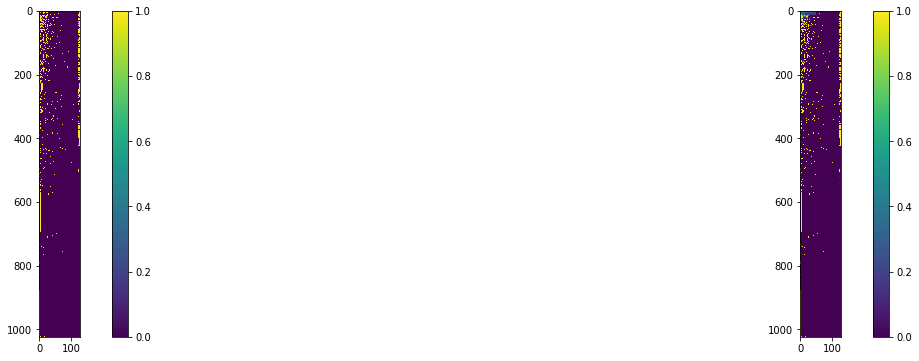

0.0
0.9657312


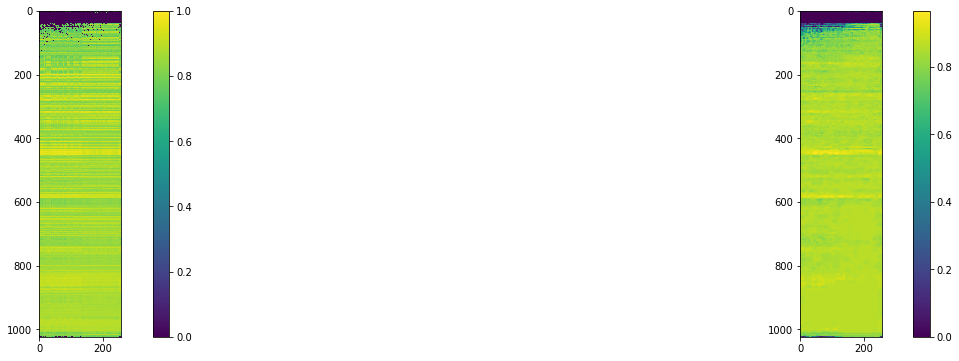

9.107102e-12
0.74356383


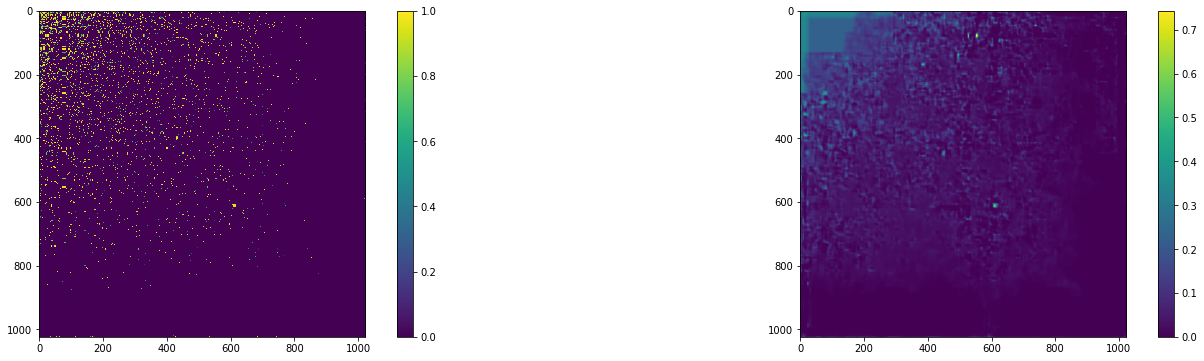

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_00/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack2 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


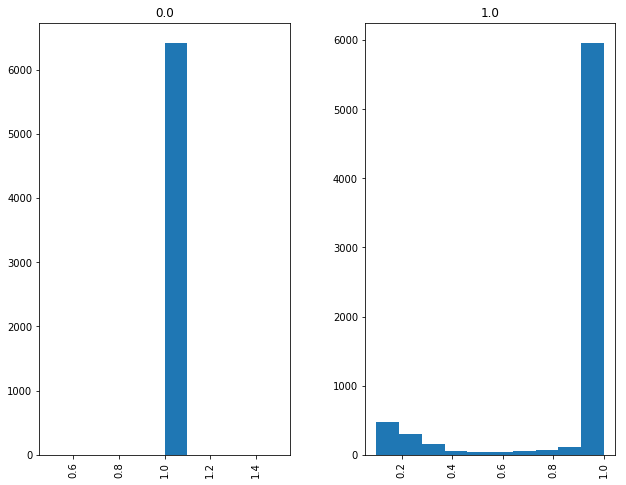

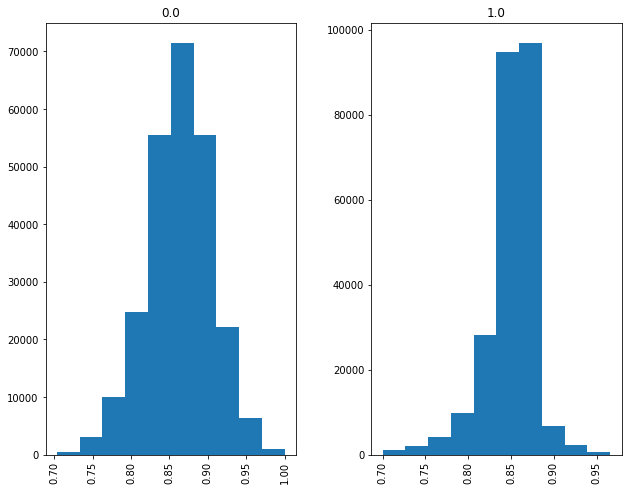

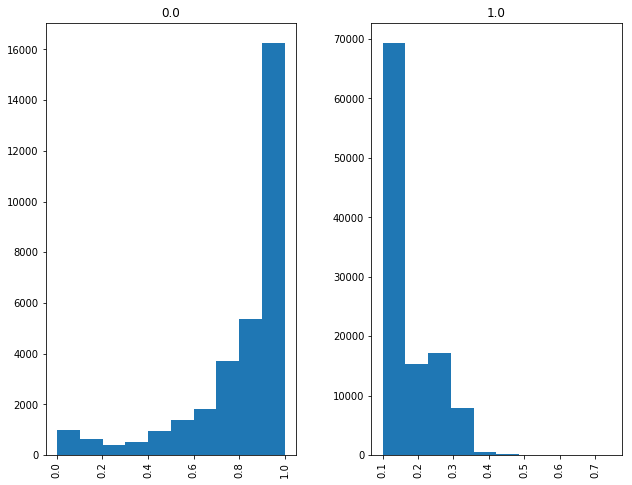

In [9]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    df = pd.DataFrame(data)
    df.hist(by=indeces, bins=10, figsize=(10, 8))
    

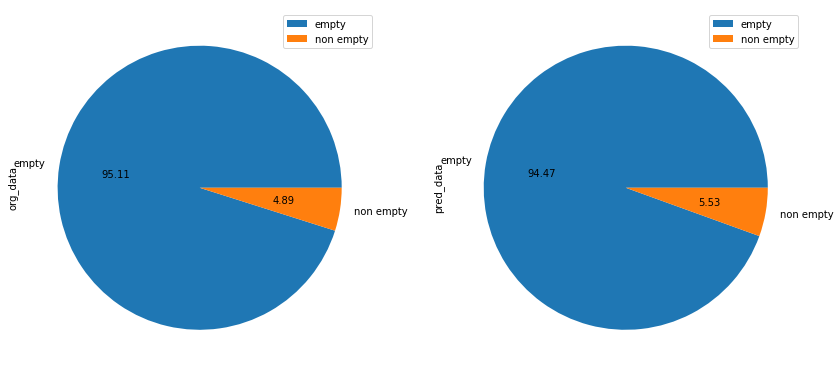

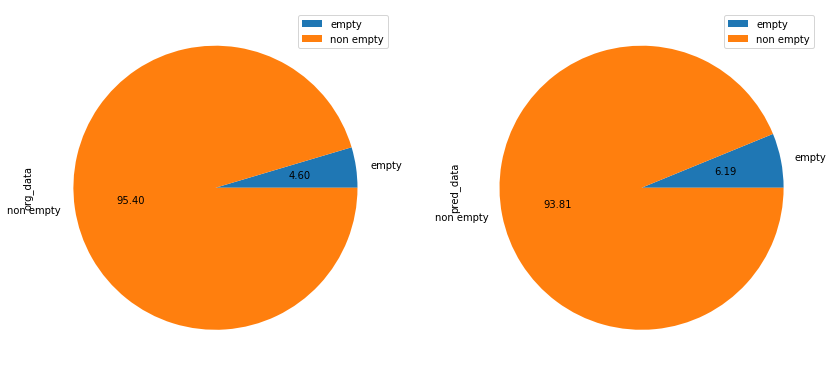

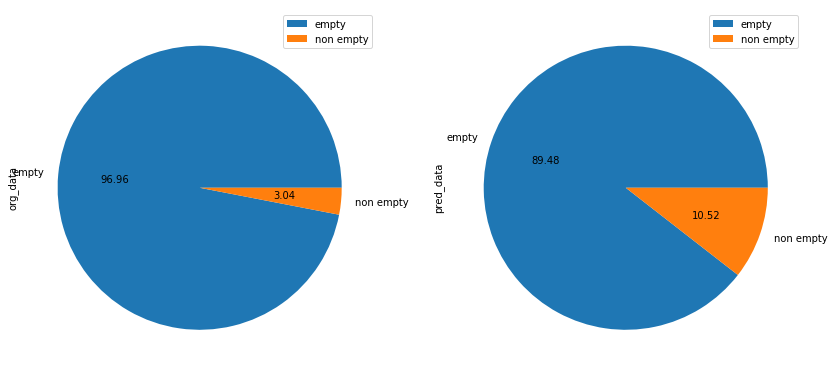

In [61]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['org_data'] = []
    d['org_data'].append(len(org_data[org_data == 0]) / length)
    d['org_data'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['pred_data'] = []
        d['pred_data'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['pred_data'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['pred_data'] = []
        d['pred_data'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['pred_data'].append(len(pred_data[pred_data > 0.1]) / length)

    df = pd.DataFrame(d, index=['empty', 'non empty'])
    plot = df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f')


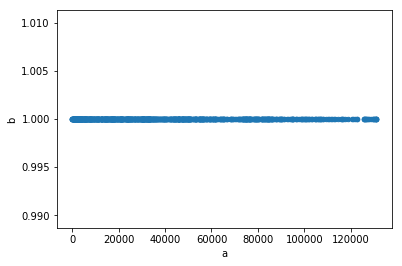

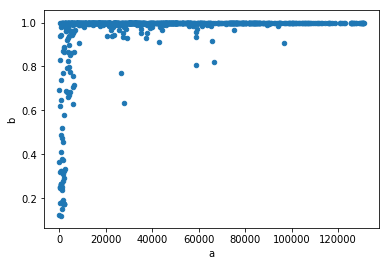

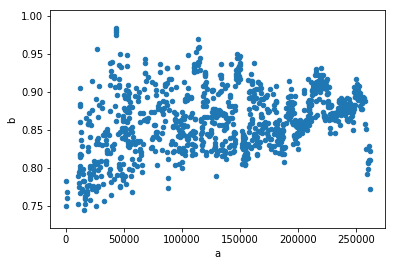

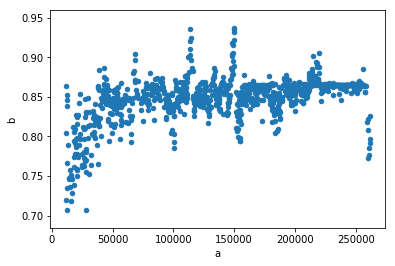

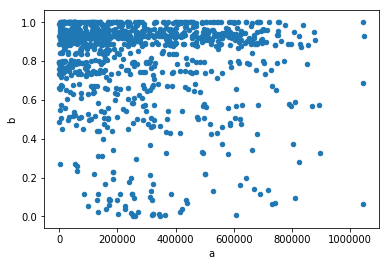

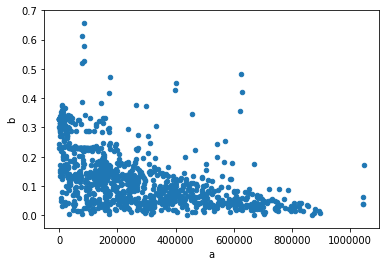

In [62]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

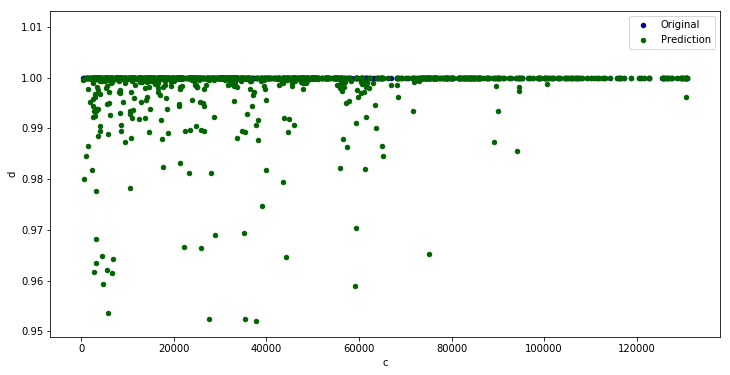

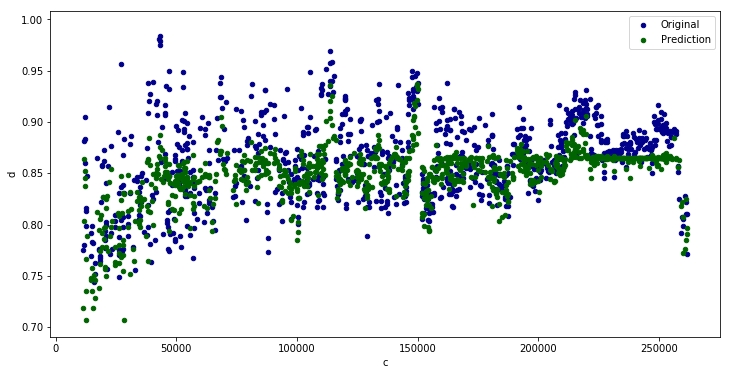

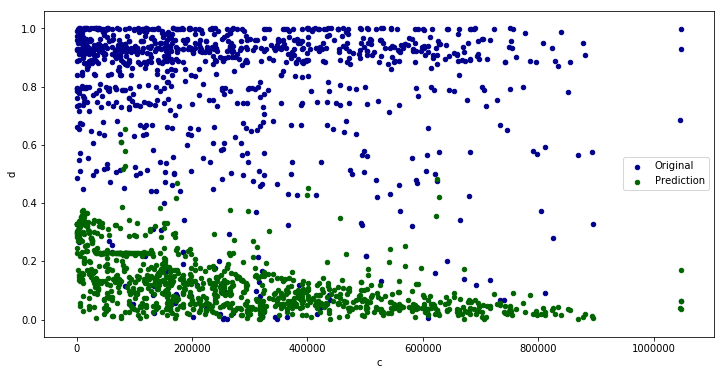

In [85]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

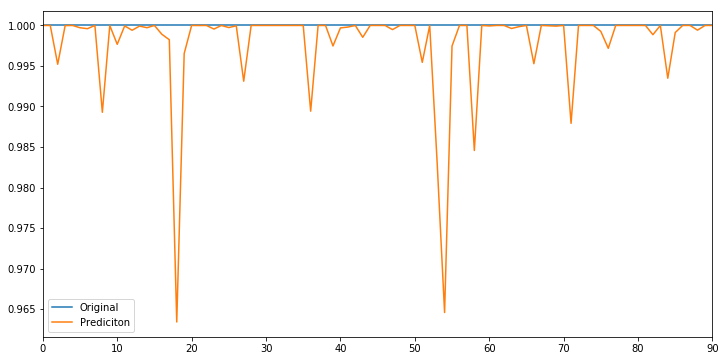

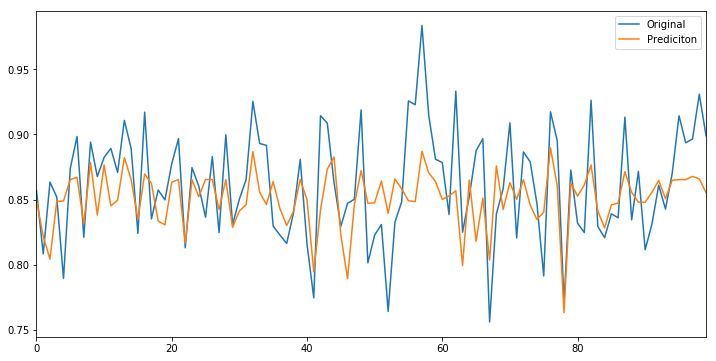

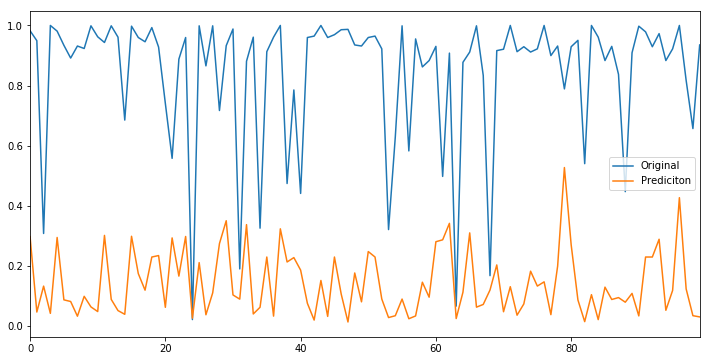

In [102]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
#                 data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
#                 data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
                data.append([org_data[j][1], predict_data[j][1]])
        else:
#             data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
            data.append([org_data[j][1], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    
#     ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
#     df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    df.plot(subplots=False, figsize=(12,6));